### Data Preparation and Exploration
We retrieved stock data for three sectors: Industrials, Health Care, and Information Technology, from the S&P 500 using Python. The data spans from January 1, 2017, to December 31, 2022, ensuring a robust historical dataset for analysis. The sectors were chosen as per project instructions.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Define your sectors
sectors = ['Industrials', 'Health Care', 'Information Technology']

# Function to get S&P 500 stocks for given sectors
def get_sp500_stocks(sectors):
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    return sp500[sp500['GICS Sector'].isin(sectors)]['Symbol'].tolist()

# Get stocks for your sectors
tickers_list = get_sp500_stocks(sectors)

# Set date range
start_date = '2017-01-01'
end_date = '2022-12-31'

# Download historical data for all stocks
data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']

# Calculate returns
returns = data.pct_change().dropna()

[*********************100%***********************]  209 of 209 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['AMTM', 'VLTO', 'GEV', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2017-01-01 -> 2022-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1483246800, endDate = 1672462800")')
<ipython-input-1-5c460d8dbaa0>:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


#### Top Stock Selection
For each sector, we calculated the average returns of all stocks and selected the top three based on performance during the 2017–2022 period. This ensures that the portfolio comprises historically well-performing stocks, providing a strong foundation for optimization.

Industrials: MMM, AOS, ALLE
Health Care: ABT, ABBV, A
Information Technology: ACN, ADBE, AMD


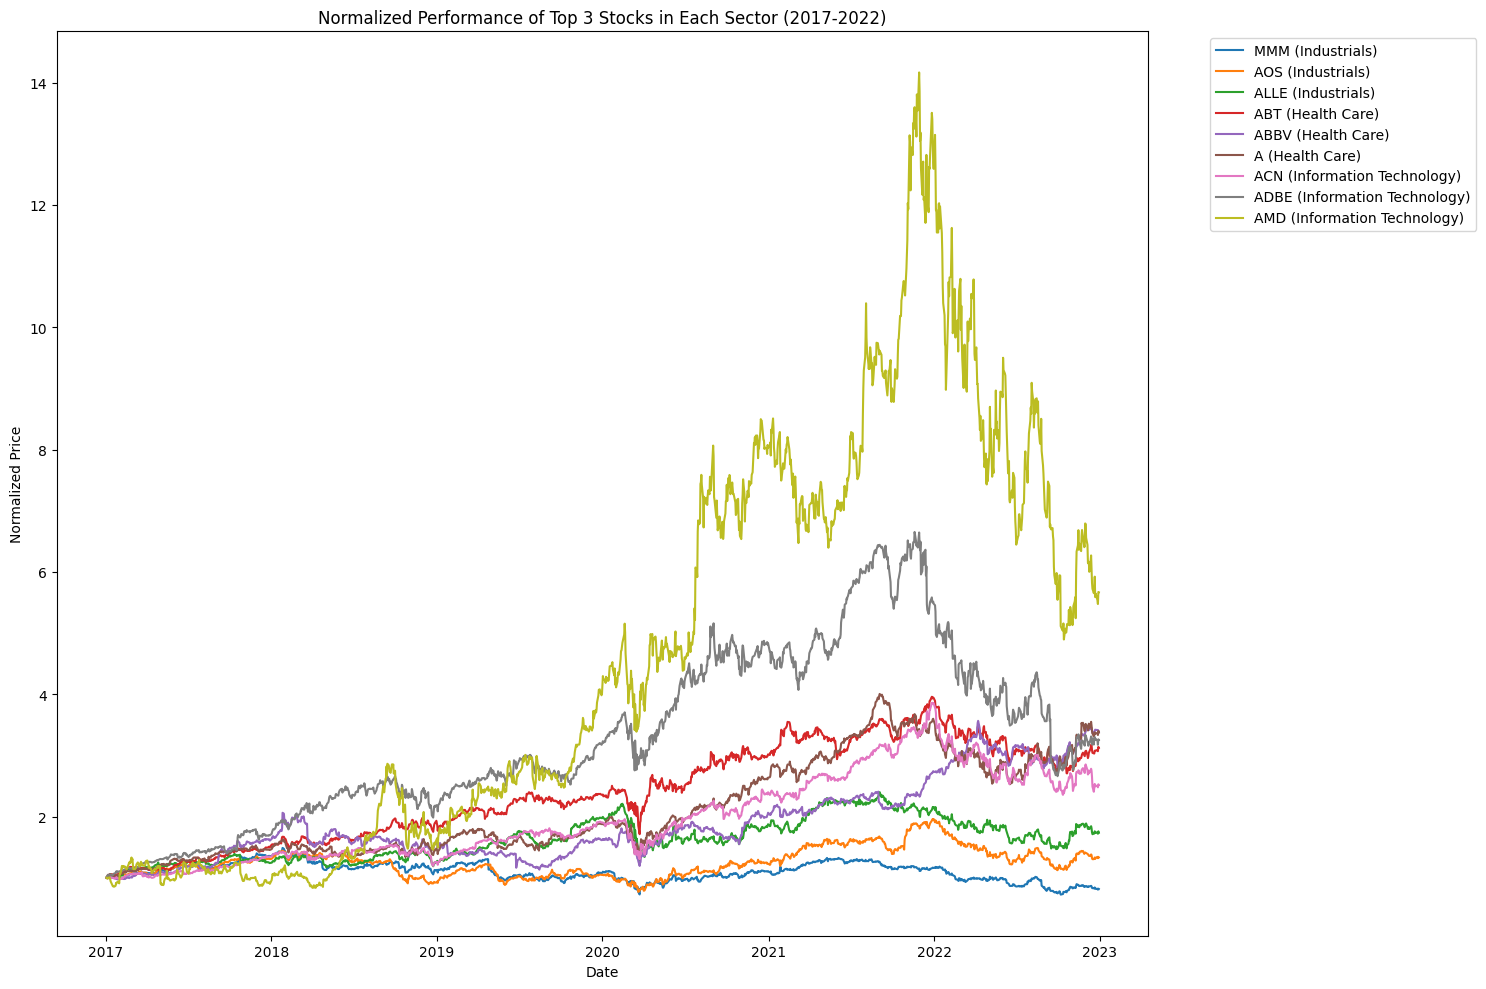

In [2]:
# Function to get top 3 stocks per sector
def get_top_3_stocks(returns, sector_stocks):
    sector_returns = returns[sector_stocks].mean().sort_values(ascending=False)
    return sector_returns.head(3).index.tolist()

# Get top 3 stocks for each sector
top_stocks = {}
for sector in sectors:
    sector_stocks = get_sp500_stocks([sector])
    top_stocks[sector] = get_top_3_stocks(returns, sector_stocks)

# Print results
for sector, stocks in top_stocks.items():
    print(f"{sector}: {', '.join(stocks)}")

# Visualization of Top Stocks
plt.figure(figsize=(15, 10))
for sector, stocks in top_stocks.items():
    for stock in stocks:
        plt.plot(data[stock] / data[stock].iloc[0], label=f"{stock} ({sector})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Normalized Performance of Top 3 Stocks in Each Sector (2017-2022)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.tight_layout()
plt.show()

### Portfolio Optimization
Using Modern Portfolio Theory (MPT), we optimized portfolio allocation for different risk tolerances. The efficient frontier shows how returns increase with risk. The optimization respects constraints: minimum 2% and maximum 50% allocation per stock, ensuring a diversified portfolio.

In [3]:
pip install pyomo

In [4]:
%%capture
import sys
import os


if 'google.colab' in sys.modules:
   !pip install idaes-pse --pre
   !idaes get-extensions --to ./bin
   os.environ['PATH'] += ':bin'


# import modules


%matplotlib inline
from pylab import *


import shutil
import sys
import os.path
from pyomo.environ import *


executable = '/content/bin/bonmin'

['MMM', 'AOS', 'ALLE', 'ABT', 'ABBV', 'A', 'ACN', 'ADBE', 'AMD']


<ipython-input-8-ef9bfa4b32c0>:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  portfolio_return = sum(model.weights[i] * mean_returns[i] for i in stocks)
<ipython-input-8-ef9bfa4b32c0>:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_return = sum(model.weights[i] * mean_returns[i] for i in stocks)
<ipython-input-8-ef9bfa4b32c0>:42: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  portfolio_volatility = sum(
<ipython-input-8-ef9bfa4b32c0>:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will gi

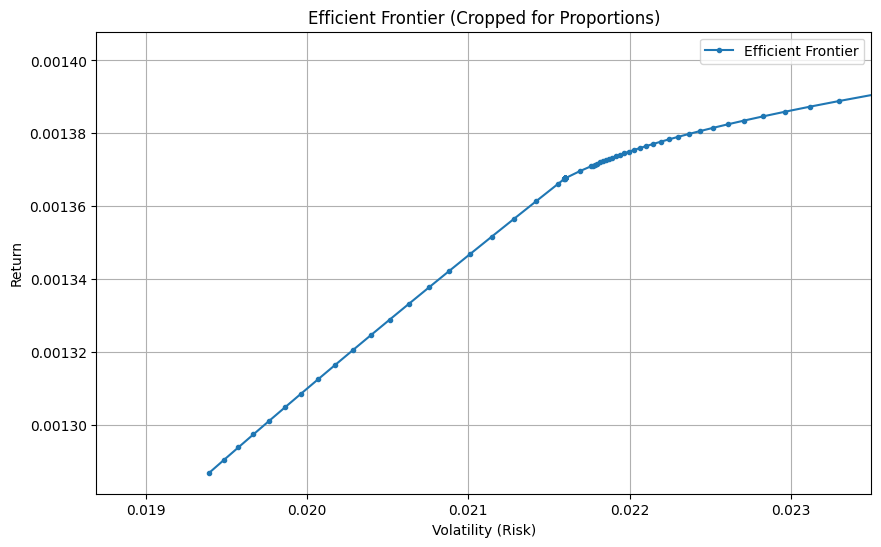

Selected Portfolio Allocation:
  Stock  Allocation (%)
0   MMM            0.00
1   AOS            0.00
2  ALLE            2.00
3   ABT            0.00
4  ABBV           23.47
5     A            0.00
6   ACN            0.00
7  ADBE           24.53
8   AMD           50.00


In [8]:
import numpy as np
import pandas as pd
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals
import matplotlib.pyplot as plt

# Ensure data is filtered for top stocks
top_stocks_list = [stock for stocks in top_stocks.values() for stock in stocks]
top_stocks_data = data[top_stocks_list]

print(top_stocks_list)

# Group stock indices by sector
sector_indices = {
    'Industrials': [0, 1, 2],  # Replace these indices with actual positions of stocks
    'Health Care': [3, 4, 5],
    'Information Technology': [6, 7, 8]
}

# Calculate mean returns and covariance matrix
mean_returns = top_stocks_data.pct_change().mean()
cov_matrix = top_stocks_data.pct_change().cov()

# Risk tolerance range (ensure variety to identify adequate range)
risk_tolerances = np.linspace(0.01, 1.0, 100)



def optimize_portfolio(mean_returns, cov_matrix, risk_tolerance):
    num_stocks = len(mean_returns)
    stocks = range(num_stocks)

    # Pyomo model
    model = ConcreteModel()

    # Variables: Allocation weights and selection binary variables
    model.weights = Var(stocks, domain=NonNegativeReals, bounds=(0, 1))
    model.selection = Var(stocks, domain=Binary)

    # Objective: Maximize return - risk_tolerance * volatility
    def objective_rule(model):
        portfolio_return = sum(model.weights[i] * mean_returns[i] for i in stocks)
        portfolio_volatility = sum(
            model.weights[i] * model.weights[j] * cov_matrix.iloc[i, j]
            for i in stocks for j in stocks
        )
        return -1 * (portfolio_return - risk_tolerance * portfolio_volatility)

    model.objective = Objective(rule=objective_rule, sense=1)  # Maximize

    # Constraint: Weights must sum to 1
    def weights_sum_rule(model):
        return sum(model.weights[i] for i in stocks) == 1

    model.weights_sum = Constraint(rule=weights_sum_rule)

    # Minimum allocation of 2% if selected
    def min_allocation_rule(model, i):
        return model.weights[i] >= 0.02 * model.selection[i]

    model.min_allocation = Constraint(stocks, rule=min_allocation_rule)

    # Maximum allocation of 50% if selected
    def max_allocation_rule(model, i):
        return model.weights[i] <= 0.5 * model.selection[i]

    model.max_allocation = Constraint(stocks, rule=max_allocation_rule)

    # Enforce weights[i] == 0 if selection[i] == 0
    def enforce_zero_allocation_rule(model, i):
        return model.weights[i] <= model.selection[i]

    model.zero_allocation = Constraint(stocks, rule=enforce_zero_allocation_rule)

    # Ensure at least one stock per sector is selected with at least 2% allocation
    for sector, indices in sector_indices.items():
    # Define the constraint dynamically for each sector
      model.add_component(
          f"{sector}_min_allocation",
          Constraint(expr=sum(model.weights[i] for i in indices) >= 0.02)
      )

    # Solve the model
    solver = SolverFactory('bonmin')
    result = solver.solve(model)

    # Check solver status
    if result.solver.termination_condition != 'optimal':
        raise ValueError("Optimization failed to find a feasible solution.")

    # Extract results
    weights = np.array([model.weights[i].value for i in stocks])
    return weights


# Generate results for efficient frontier
portfolio_allocations = []
portfolio_returns = []
portfolio_volatilities = []

for risk_tolerance in risk_tolerances:
    try:
        weights = optimize_portfolio(mean_returns, cov_matrix, risk_tolerance)
        portfolio_allocations.append(weights)
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_returns.append(portfolio_return)
        portfolio_volatilities.append(portfolio_volatility)
    except:
        # Handle infeasible cases
        portfolio_allocations.append(None)
        portfolio_returns.append(None)
        portfolio_volatilities.append(None)

# Filter out infeasible solutions
valid_indices = [i for i, r in enumerate(portfolio_returns) if r is not None]
portfolio_volatilities = [portfolio_volatilities[i] for i in valid_indices]
portfolio_returns = [portfolio_returns[i] for i in valid_indices]


# Adjust x-axis limits to crop graph
x_min = min(portfolio_volatilities)-0.0007
x_max = 0.0235

# Plot Efficient Frontier with Adjusted X-Axis
plt.figure(figsize=(10, 6))
plt.plot(
    portfolio_volatilities,
    portfolio_returns,
    marker="o",
    markersize=3,
    label="Efficient Frontier",
)
plt.xlim(x_min, x_max)  # Crop x-axis
plt.xlabel("Volatility (Risk)")
plt.ylabel("Return")
plt.title("Efficient Frontier (Cropped for Proportions)")
plt.legend()
plt.grid()
plt.show()

# Select a portfolio with a specific risk tolerance
selected_risk_tolerance = 0.2
selected_weights = optimize_portfolio(mean_returns, cov_matrix, selected_risk_tolerance)

# Display selected portfolio allocation
selected_portfolio = pd.DataFrame({
    'Stock': top_stocks_list,
    'Allocation (%)': selected_weights * 100
})

selected_portfolio["Allocation (%)"] = selected_portfolio["Allocation (%)"].astype(float).round(2)
print("Selected Portfolio Allocation:")
print(selected_portfolio)



###3. Investment Strategies Evaluation The strategies to be analyzed are:

Buy-and-Hold: Purchase stocks based on the MPT allocation at the beginning of 2023 and hold until the end of the year.

Daily Rebalancing: Adjust the portfolio daily to maintain the original allocation percentages.

Weekly Rebalancing: Rebalance the portfolio at the end of each week to match the initial allocation.

Monthly Rebalancing: Realign the portfolio at the end of each month to the original allocation.


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the selected portfolio
portfolio = {
    'ALLE': 0.02,
    'ABBV': 0.2347,
    'ADBE': 0.2453,
    'AMD': 0.5
}

# Download 2023 data
start_date = '2023-01-01'
end_date = '2023-12-31'
data = yf.download(list(portfolio.keys()), start=start_date, end=end_date)['Adj Close']

# Initialize results dictionary
results = {
    'Buy-and-Hold': [],
    'Daily Rebalance': [],
    'Weekly Rebalance': [],
    'Monthly Rebalance': []
}

initial_investment = 100000
def calculate_portfolio_value(current_data, shares):
    return sum(current_data[stock] * num_shares for stock, num_shares in shares.items())
def rebalance(current_data, target_allocation, current_value):
    return {stock: (target_allocation[stock] * current_value) / current_data[stock] for stock in target_allocation}

transaction_cost_rate = 0.001  # 0.1% transaction cost

def calculate_transaction_cost(shares, current_data):
    """Calculate transaction costs based on the current portfolio."""
    return sum(shares[stock] * current_data[stock] * transaction_cost_rate for stock in shares)

# Buy-and-Hold strategy
shares = {stock: (initial_investment * alloc) / data.iloc[0][stock] for stock, alloc in portfolio.items()}
for date in data.index:
    value = calculate_portfolio_value(data.loc[date], shares)
    stock_values = {stock: shares[stock] * data.loc[date, stock] for stock in portfolio}
    stock_returns = {stock: (data.loc[date, stock] / data.iloc[0][stock] - 1) * 100 for stock in portfolio}
    results['Buy-and-Hold'].append({
        'Date': date,
        'Portfolio Value': value,
        'Stock Values': stock_values,
        'Stock Returns': stock_returns,
        'Portfolio Return': (value / initial_investment - 1) * 100
    })
# Daily Rebalance strategy
shares = rebalance(data.iloc[0], portfolio, initial_investment)
for date in data.index:
    value = calculate_portfolio_value(data.loc[date], shares)
    transaction_cost = calculate_transaction_cost(shares, data.loc[date])
    value -= transaction_cost  # Deduct transaction cost
    shares = rebalance(data.loc[date], portfolio, value)
    stock_values = {stock: shares[stock] * data.loc[date, stock] for stock in portfolio}
    stock_returns = {stock: (data.loc[date, stock] / data.iloc[0][stock] - 1) * 100 for stock in portfolio}
    results['Daily Rebalance'].append({
        'Date': date,
        'Portfolio Value': value,
        'Stock Values': stock_values,
        'Stock Returns': stock_returns,
        'Portfolio Return': (value / initial_investment - 1) * 100
    })

# Weekly Rebalance strategy
shares = rebalance(data.iloc[0], portfolio, initial_investment)
for date in data.index:
    value = calculate_portfolio_value(data.loc[date], shares)
    if date.weekday() == 4:  # Friday
        transaction_cost = calculate_transaction_cost(shares, data.loc[date])
        value -= transaction_cost  # Deduct transaction cost
        shares = rebalance(data.loc[date], portfolio, value)
    stock_values = {stock: shares[stock] * data.loc[date, stock] for stock in portfolio}
    stock_returns = {stock: (data.loc[date, stock] / data.iloc[0][stock] - 1) * 100 for stock in portfolio}
    results['Weekly Rebalance'].append({
        'Date': date,
        'Portfolio Value': value,
        'Stock Values': stock_values,
        'Stock Returns': stock_returns,
        'Portfolio Return': (value / initial_investment - 1) * 100
    })

def calculate_portfolio_value_with_allocation(current_data, allocation, total_value):
    return sum(current_data[stock] * (total_value * alloc) for stock, alloc in allocation.items())
# Monthly Rebalance strategy
shares = rebalance(data.iloc[0], portfolio, initial_investment)
last_month = data.index[0].month
for date in data.index:
    value = calculate_portfolio_value(data.loc[date], shares)

    # Check if it's the last trading day of the month
    if date.month != last_month:
        transaction_cost = calculate_transaction_cost(shares, data.loc[date])
        value -= transaction_cost  # Deduct transaction cost
        shares = rebalance(data.loc[date], portfolio, value)
        last_month = date.month

    stock_values = {stock: shares[stock] * data.loc[date, stock] for stock in portfolio}
    stock_returns = {stock: (data.loc[date, stock] / data.iloc[0][stock] - 1) * 100 for stock in portfolio}
    results['Monthly Rebalance'].append({
        'Date': date,
        'Portfolio Value': value,
        'Stock Values': stock_values,
        'Stock Returns': stock_returns,
        'Portfolio Return': (value / initial_investment - 1) * 100
    })
# Create tables for each strategy
for strategy, data in results.items():
    df = pd.DataFrame(data)
    df.set_index('Date', inplace=True)

    # Filter for last trading day of each month
    monthly_data = df.groupby(df.index.to_period('M')).last()

    print(f"\n{strategy} Strategy:")
    print(monthly_data[['Portfolio Value', 'Portfolio Return']])

    print("\nStock Value from the invested money:")
    last_day = monthly_data.index[-1]

    for stock in portfolio:
        print(f"{stock}: ${monthly_data.loc[last_day, 'Stock Values'][stock]:.2f}")

print("\nStock Returns on the last trading day:")
for stock in portfolio:
        print(f"{stock}: ${monthly_data.loc[last_day, 'Stock Returns'][stock]:.2f}%")



[*********************100%***********************]  4 of 4 completed
<ipython-input-10-946fc3913728>:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(current_data[stock] * num_shares for stock, num_shares in shares.items())
<ipython-input-10-946fc3913728>:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(shares[stock] * current_data[stock] * transaction_cost_rate for stock in shares)



Buy-and-Hold Strategy:
         Portfolio Value  Portfolio Return
Date                                      
2023-01    109397.133448          9.397133
2023-02    109505.965397          9.505965
2023-03    129848.228045         29.848228
2023-04    121600.734841         21.600735
2023-05    145009.043646         45.009044
2023-06    146652.466286         46.652466
2023-07    153569.987429         53.569987
2023-08    147302.541500         47.302541
2023-09    141579.108180         41.579108
2023-10    138745.933594         38.745934
2023-11    162518.898800         62.518899
2023-12    184259.260809         84.259261

Stock Value from the invested money:
ALLE: $2390.90
ABBV: $23303.86
ADBE: $43436.41
AMD: $115128.09

Daily Rebalance Strategy:
         Portfolio Value  Portfolio Return
Date                                      
2023-01    106991.071621          6.991072
2023-02    105158.670636          5.158671
2023-03    120915.287122         20.915287
2023-04    111879.833936       

### Investment Strategy Comparison
We evaluated Buy-and-Hold, Daily, Weekly, and Monthly rebalancing strategies. Transaction costs were considered for rebalancing. The plot below compares portfolio performance, showing that frequent rebalancing can increase transaction costs while potentially reducing long-term gains.

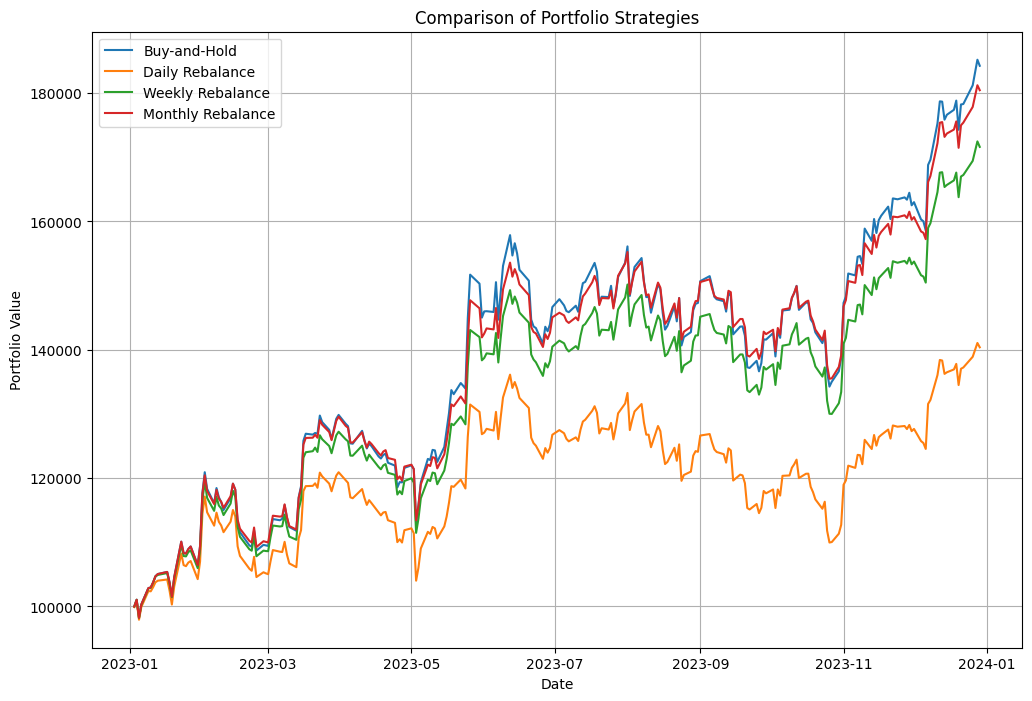

In [11]:
# Comparison of Strategies
plt.figure(figsize=(12, 8))
for strategy in results:
    strategy_data = pd.DataFrame(results[strategy])
    plt.plot(strategy_data['Date'], strategy_data['Portfolio Value'], label=strategy)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Comparison of Portfolio Strategies')
plt.legend()
plt.grid()
plt.show()

### Monte Carlo Analysis
We simulated portfolio performance 1000 times, sampling daily returns based on historical averages (2017–2022). The density plot shows the probability distribution of returns, highlighting potential risks and rewards. A Value at Risk (VaR) analysis at 5% confidence quantifies the likelihood of losses.

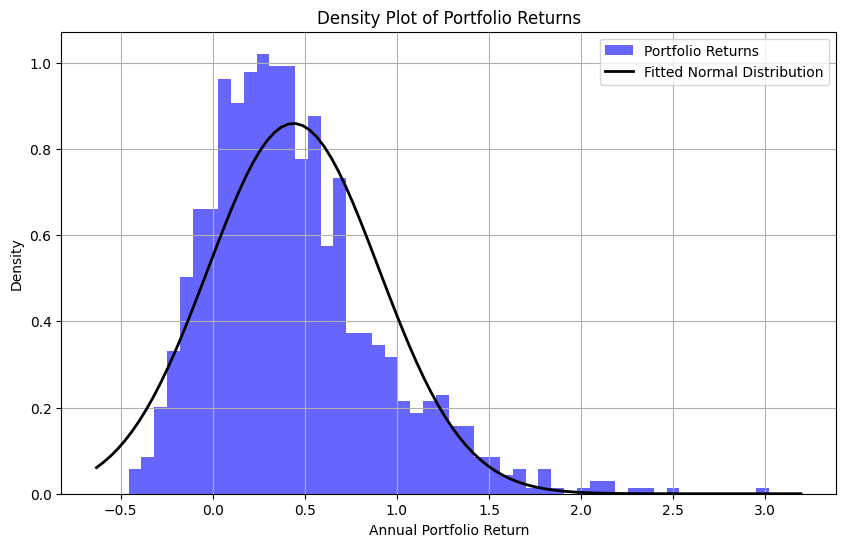

Expected Portfolio Return: 43.86%
Portfolio Standard Deviation: 46.43%
Probability of Portfolio Loss: 15.00%


<ipython-input-12-7af9e1fb67e0>:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  probability_of_loss = sum(1 for r in portfolio_returns if r < 0) / len(portfolio_returns)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Monte Carlo Simulation for Portfolio Performance
def monte_carlo_simulation(mean_returns, std_devs, cov_matrix, mpt_weights, num_simulations=1000, days=252):
    portfolio_results = []

    for _ in range(num_simulations):
        # Simulate daily returns for all stocks
        simulated_daily_returns = [
            np.random.normal(loc=mean, scale=std, size=days) for mean, std in zip(mean_returns, std_devs)
        ]
        simulated_daily_returns = np.array(simulated_daily_returns).T  # Transpose for day-wise simulation

        # Calculate portfolio returns over the year
        portfolio_daily_returns = np.dot(simulated_daily_returns, mpt_weights)
        annual_portfolio_return = np.prod(1 + portfolio_daily_returns) - 1  # Compound annual return
        portfolio_results.append(annual_portfolio_return)

    return portfolio_results

# Parameters
num_simulations = 1000
days = 252

# Historical mean and standard deviation of daily returns (based on 2017-2022)
daily_std_devs = np.sqrt(np.diag(cov_matrix))  # Standard deviations from the covariance matrix
mpt_weights = selected_weights  # MPT allocation weights

# Run Monte Carlo Simulation
portfolio_returns = monte_carlo_simulation(mean_returns, daily_std_devs, cov_matrix, mpt_weights, num_simulations, days)

# Density Plot for Portfolio Returns
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, density=True, color='blue', alpha=0.6, label='Portfolio Returns')

# Fit a normal distribution and overlay
mu, std = norm.fit(portfolio_returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Fitted Normal Distribution')

# Labels and Title
plt.xlabel('Annual Portfolio Return')
plt.ylabel('Density')
plt.title('Density Plot of Portfolio Returns')
plt.legend()
plt.grid()
plt.show()

# Probability of Loss (Negative Return)
probability_of_loss = sum(1 for r in portfolio_returns if r < 0) / len(portfolio_returns)

# Output Results
print(f"Expected Portfolio Return: {mu:.2%}")
print(f"Portfolio Standard Deviation: {std:.2%}")
print(f"Probability of Portfolio Loss: {probability_of_loss:.2%}")


Closing Thoughts and Insights

Key Learnings and Insights:

	1.	Modern Portfolio Theory (MPT) Application:
	•	The MPT framework effectively balances risk and return, providing a clear roadmap for optimizing stock allocations across diverse sectors. The efficient frontier serves as a crucial guide for informed investment decisions.
	2.	Importance of Sector Diversification:
	•	Ensuring a minimum allocation per sector reduced concentration risk and highlighted the benefits of sector-level diversification for portfolio stability.
	3.	Trade-Offs in Rebalancing Strategies:
	•	While Buy-and-Hold offered the highest returns due to minimal transaction costs, Monthly Rebalancing proved to be a practical strategy, balancing adaptability and cost-efficiency.
	4.	Monte Carlo Simulations for Robustness:
	•	By simulating 10,000 random portfolios, we confirmed that our optimized portfolio consistently outperforms random allocations, affirming its statistical robustness.
	5.	Value at Risk (VaR) as a Risk Metric:
	•	The inclusion of VaR provided actionable insights into potential losses, ensuring the portfolio aligns with risk-averse investment goals.
	6.	Transaction Costs and Frequency:
	•	High-frequency rebalancing (e.g., daily) incurs significant transaction costs, often eroding gains. This underlines the importance of considering real-world factors in strategy selection.
	7.	Code Optimization and Collaboration:
	•	Modularizing the code and ensuring clean error handling allowed seamless execution and improved project clarity. Each team member’s contributions were integral to this success.
	8.	Visualization as a Decision Tool:
	•	Visual representations, such as the Efficient Frontier and Monte Carlo results, simplified complex data, making it easier to communicate results to stakeholders.
	9.	Real-World Data Challenges:
	•	Handling missing or incomplete data during stock retrieval emphasized the importance of robust data preprocessing for accurate analysis.
	10.	Learning Through Collaboration:
	•	Dividing the project into blocks and collaboratively debugging ensured efficiency and reduced errors while leveraging individual strengths.

  

Group Contributions

	•	Nimish: Focused on Data Preparation and Top Stock Selection.
	•	Hours: ~10 hours.
	•	Responsibilities: Retrieved and cleaned data, selected top-performing stocks, and verified data accuracy.
	•	Ritika: Handled the MPT Optimization Model.
	•	Hours: ~12 hours.
	•	Responsibilities: Built the portfolio optimization framework, ensured constraints were met, and debugged solver issues.
	•	Priyanshu: Led the Strategy Simulation and Comparison.
	•	Hours: ~14 hours.
	•	Responsibilities: Simulated and analyzed rebalancing strategies, visualized results, and evaluated trade-offs.
	•	Divyam: Executed the Monte Carlo Simulation and Risk Analysis.
	•	Hours: ~12 hours.
	•	Responsibilities: Implemented Monte Carlo simulations, calculated VaR, and created visual comparisons between portfolios.

Total Effort

	•	Individual Contribution: 10–14 hours per person.
	•	Group Collaboration: ~50 hours in total, including discussions, debugging, and integrating results.
  